<a href="https://colab.research.google.com/github/penelopetir/BIOL74-Final-Project/blob/main/Final_Project_Spike_Threshold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Before starting, we'll install neuron in our current runtime as usual.

In [ ]:
%pip install neuron # only need to run this cell once to install
                    # neuron in the local jupyter environment

Run the code block below just once to get all the files from the repository into our colab session and compile the MOD mechanism files we'll be using

In [ ]:
repo_name = 'BIOL74-Final-Project'
if 'google.colab' in str(get_ipython()):
    import os
    if not os.path.exists(repo_name):
        !git clone https://github.com/penelopetir/{repo_name}.git # downloads repository into our Google colab session's file system

    os.chdir(repo_name) # Changing working directory to downloaded repository

# Compile mechanisms
!nrnivmodl mechanisms

Cloning into 'BIOL74-Final-Project'...
remote: Enumerating objects: 399, done.
remote: Counting objects: 100% (217/217), done.
remote: Compressing objects: 100% (124/124), done.
remote: Total 399 (delta 133), reused 162 (delta 91), pack-reused 182
Receiving objects: 100% (399/399), 1.28 MiB | 4.31 MiB/s, done.
Resolving deltas: 100% (226/226), done.
/content/BIOL74-Final-Project/BIOL74-Final-Project
Mod files: "mechanisms/mechanisms/CadepK.mod" "mechanisms/mechanisms/Ca.mod"

Creating 'x86_64' directory for .o files.

 -> Compiling mod_func.cpp
 -> NMODL ../mechanisms/CadepK.mod
 -> NMODL ../mechanisms/Ca.mod
Translating CadepK.mod into /content/BIOL74-Final-Project/BIOL74-Final-Project/x86_64/CadepK.c
Translating Ca.mod into /content/BIOL74-Final-Project/BIOL74-Final-Project/x86_64/Ca.c
Thread Safe
Thread Safe
 -> Compiling CadepK.c
 -> Compiling Ca.c
 => LINKING shared library ./libnrnmech.so
 => LINKING executable ./special LDFLAGS are:    -pthread
Successfully created x86_64/specia

## Introduction
For this exercise, we'll be adapting a model of a L5PC to model granule neurons traced from wild type and PTEN KO groups


Start by importing the packages we'll be using.

In [ ]:
from neuron import h # all NEURON hoc functions are accessed through h
from neuron import gui # if you're running this notebook in a local environment (instead of on google colab), launches the GUI
h.load_file('stdrun.hoc') # loads neuron standard hoc library, not always necessary
import numpy as np
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
import matplotlib.pyplot as plt
import plotly
from plotly.subplots import make_subplots
import plotly.graph_objects as go

if 'google.colab' in str(get_ipython()): # For making interactive plots work on google colab
    from google.colab import output
    output.enable_custom_widget_manager()
else:
    plotly.offline.init_notebook_mode() # for printing notebooks offline

#Importing Morphologies

Files from the github of traced neurons from NeuroLuicda 360 are imported and created with proper morphology. Biophysics are modeled after the Aradi et al 1999 paper.

In [ ]:
from helper_functions import createGranuleCell

genotype = "KO" #change this string to "WT" or "KO" to determine which neuron to run the following code on

if genotype == "WT":
  WT_file = "morphologies/WT.asc" # morphology file
  GC = createGranuleCell(WT_file, "active")
elif genotype == "KO":
  KO_file = "morphologies/PTEN_KO.asc" # morphology file
  GC = createGranuleCell(KO_file, "active")
else:
  print("No neuron found")

# Create recording vectors for time and somatic voltage
t_vec = h.Vector().record(h._ref_t)
v_soma = h.Vector().record(GC.soma[0](0.5)._ref_v)

In [ ]:
#creating current clamp
iclamp = h.IClamp(GC.soma[0](0.5))

#generating a recording vector for current
i_vec = h.Vector().record(iclamp._ref_i)

#current clamp settings
iclamp.amp = 0.001 #nA
iclamp.dur = 15 #ms
iclamp.delay = 5

In [ ]:
#simulation settings
h.v_init = -70 # mV - initial voltage of the model system
h.dt = 0.1  # ms - time step
h.celsius = 37 # degrees celsius - ephys recordings at this temp
h.tstop = 30 # ms - simulation duration

if genotype == "WT":
  amps = np.arange(0,0.089,0.005) #WT neuron
else:
  amps = np.arange(0.1,0.185,0.01) #KO neuron

fig = make_subplots(rows=2,cols=1)
for amp in amps:
  iclamp.amp = amp
  h.run()
  # voltage
  fig.add_trace(go.Scatter(x=t_vec,y=v_soma,showlegend=True),row=1,col=1)
  fig['layout']['yaxis']['title']='Vm (mV)'
  # Current
  fig.add_trace(go.Scatter(x=t_vec,y=i_vec,showlegend=False),row=2,col=1)
  fig['layout']['xaxis2']['title']='time (ms)'
  fig['layout']['yaxis2']['title']='Ic (nA)'

fig.show()


Changed dt


In [ ]:
#helper functions to compute threshold voltage

def find_index(num, vector):
  diff = [np.abs(element - num) for element in np.array(vector)]
  return np.argmin(diff)

def find_threshold(voltage, time, tstep):
  voltage = np.array(voltage)
  # Compute the first and second derivatives
  first_deriv = np.gradient(voltage, tstep)
  second_deriv = np.gradient(first_deriv, tstep)
  # Find the index of the maximum second derivative
  loc_Vt = np.argmax(second_deriv) - 15 #1ms before maximum reached
  # Return the voltage at the found index
  fig = plt.figure()
  ax = fig.add_subplot(111)
  ax.plot(time, voltage, label = "Voltage")
  ax.plot(time, second_deriv, label = "Second Derivative")
  plt.xlabel("time (ms)")
  plt.ylabel("voltage (mv) or voltage 2nd derivative (mv/ms^2)")
  plt.legend()
  return voltage[loc_Vt], time[loc_Vt]

KO Threshold Voltage: -44.52732067270084mV at t = 19.774999999999412


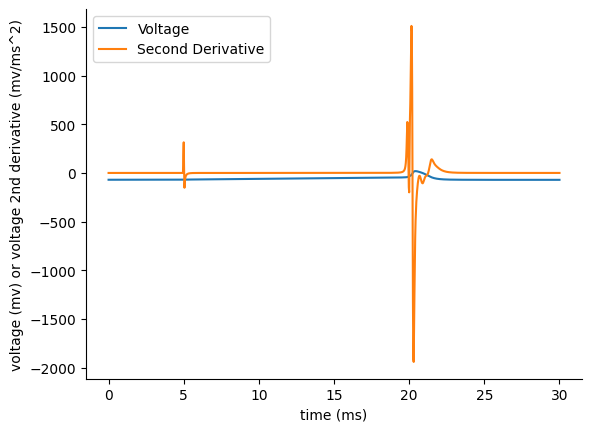

In [ ]:
v_thresh, t_thresh = find_threshold(v_soma, t_vec, h.dt)
print(f"{genotype} Threshold Voltage: {v_thresh}mV at t = {t_thresh}")